<a href="https://colab.research.google.com/github/mkbensalah/Change-Detection-in-Hyperspectral-Images/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training with Hermiston Datasets ###

In [1]:
import os
import random
import itertools
from random import shuffle
import h5py
import json
import tensorflow as tf

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage 
from skimage.transform import rotate 
import spectral # Module for processing hyperspectral image data.
import matplotlib 
%matplotlib inline

# scikit-learn imports 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# keras imports 
#import keras
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import sys

In [2]:
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Dense, Conv1D, Activation, Flatten, Input, Reshape, LeakyReLU
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
import pathlib
import shutil
import tempfile
import math
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import numpy as np
from os.path import join, exists, basename, split
from spectral import *

from os import listdir
from os.path import isfile, join
from os import walk
import glob
from sklearn.model_selection import train_test_split
from spectral import *

print(tf.__version__)

C:\Users\CVR 2019 2020\AppData\Roaming\Python\Python36\site-packages\tensorflow_addons\utils\ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


2.3.0


In [3]:
### Limit GPU Memory growth ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Define data loading function

In [4]:
def load_data(name):
    images = []
    
    print(name+"----------")
    datas = []
    u = 0
    
    for filename in glob.glob(name+"/*.npy"):

        datas.append(filename)
        u = u + 1

    print("Number of Samples :    "+str(u))
        
    return datas

In [5]:
hermi_2004 = load_data(r"E:\intermediate_notebooks\hermi2004");# List containing names (string) of the datasets in hermi2004

E:\intermediate_notebooks\hermi2004----------
Number of Samples :    1943


In [6]:
hermi_2007 = load_data(r"E:\intermediate_notebooks\hermi2007");# List containing names (string) of the datasets in hermi2007

E:\intermediate_notebooks\hermi2007----------
Number of Samples :    1943


In [7]:
hermi_comb = [];
for i in range(len(hermi_2004)):
    hermi_comb.append([hermi_2004[i], hermi_2007[i]])
print(len(hermi_comb))

1943


In [8]:
hermi_comb[60]

['E:\\intermediate_notebooks\\hermi2004\\0060.npy',
 'E:\\intermediate_notebooks\\hermi2007\\0060.npy']

In [9]:
hermi_ch_gt = load_data(r"E:\intermediate_notebooks\hermi_ch_gt_cat");# List containing names (string) of the datasets in hermi2007

E:\intermediate_notebooks\hermi_ch_gt_cat----------
Number of Samples :    1943


In [15]:
np.random.seed(25)
hermi_train_im, hermi_test_im, hermi_train_lb, hermi_test_lb = train_test_split(hermi_comb, hermi_ch_gt, test_size=0.1, shuffle=True)

In [16]:
print(len(hermi_train_im))
print(len(hermi_test_im))

1748
195


## Load the pretrained cae model ##

In [10]:
cae_dim = load_model("hermi_dim_reduc_cae_v1.h5", custom_objects={"LeakyReLU":LeakyReLU()})
cae_dim.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 242)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 242)       2869878   
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 242)       484       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 200)       1210200   
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 200)       400       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 158)       790158    
_________________________________________________________________
instance_normalization_2 (In (None, 64, 64, 158)      

In [11]:
output_layer = cae_dim.layers[-12].output
print(output_layer)

Tensor("instance_normalization_5/Reshape_3:0", shape=(None, 64, 64, 32), dtype=float32)


In [12]:
cae_encoder = Model(inputs=cae_dim.input, outputs=output_layer)
cae_encoder.trainable = False;
cae_encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 242)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 242)       2869878   
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 242)       484       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 200)       1210200   
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 200)       400       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 158)       790158    
_________________________________________________________________
instance_normalization_2 (In (None, 64, 64, 158)      

# Define batch and validation data generators ###

In [33]:
def myBatchGenerator(batch_size, images, labels):  
    batch_counter = 0
    save_batch = 0
    while True:    
        batch_image = []
        batch_label = []
        while batch_counter < batch_size + save_batch:
            #rand_ind = np.random.randint(len(images));#Random index number to access list

            filename1 = images[batch_counter][0]
            filename2 = images[batch_counter][1]
            theImage1 = np.load(filename1)
            theImage2 = np.load(filename2)
            tempImage = np.zeros((2, 64, 64, theImage1.shape[2]))
            tempImage[0, :, :, :] = theImage1;
            tempImage[1, :, :, :] = theImage2;
            tempImage = cae_encoder.predict(tempImage)
            
            labelname = labels[batch_counter]
            theLabel = np.load(labelname)
            #The input image and the batch label should be the same in this case
            
            batch_image.append(tempImage)
            batch_label.append(theLabel)
            
            #print(theImage.shape)
            batch_counter = batch_counter + 1
            #print("batch_counter : "+str(batch_counter))
        #print("batch_size + save_batch : "+str(batch_size + save_batch))
        if(batch_counter == len(images)-1 or (batch_size + save_batch) > len(images)-1):
            batch_counter = 0
            save_batch = 0
            
        save_batch = batch_counter
        BI = np.array(batch_image)#.as...
        BL = np.array(batch_label)#.astype(np.float32);#Batch labe
        yield BI, BL

In [34]:
def myValidGenerator(batch_size, images, labels): #Load images in a non-random way
    
    batch_counter = 0
    while True:
        batch_image = []
        batch_label = []
        while batch_counter < batch_size:
            rand_ind = np.random.randint(len(images));#Random index number to access list
            
            filename1 = images[rand_ind][0]
            filename2 = images[rand_ind][1]
            theImage1 = np.load(filename1)
            theImage2 = np.load(filename2)
            tempImage = np.zeros((2, 64, 64, theImage1.shape[2]))
            tempImage[0, :, :, :] = theImage1;
            tempImage[1, :, :, :] = theImage2;
            tempImage = cae_encoder.predict(tempImage)
            
            labelname = labels[rand_ind]
            theLabel = np.load(labelname)
            #The input image and the batch label should be the same in this case
            
            batch_image.append(tempImage)
            batch_label.append(theLabel)

            batch_counter = batch_counter + 1
            
        batch_counter = 0
        
        BI = np.array(batch_image)#.astype(np.float32);#Batch image
#         print("Validation")
#         for i in range(len(batch_label)):
#             print(batch_label[i].shape)
            
        BL = np.array(batch_label)#.astype(np.float32);#Batch labe
        yield BI, BL;# Yield gives a sequence of values?

#### Generate training and validation data from file ####

In [35]:
BATCH_SIZE = 19; # Common divisor for 207 and 621
train_batch = myBatchGenerator(BATCH_SIZE, hermi_train_im, hermi_train_lb)
test_batch = myValidGenerator(BATCH_SIZE, hermi_test_im, hermi_test_lb)

In [36]:
theInput = Input((2, 64, 64, 32))

In [37]:
convLSTM = TimeDistributed(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU()))(theInput)
convLSTM = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation=LeakyReLU()))(convLSTM)
convLSTM = ConvLSTM2D(32, kernel_size = (3, 3),padding = 'same', return_sequences = True)(convLSTM)
convLSTM = ConvLSTM2D(16, kernel_size = (3, 3), padding = 'same', return_sequences = False)(convLSTM)
convLSTM = Dense(6, activation = 'softmax')(convLSTM)

lstm_model = Model(inputs = theInput, outputs = convLSTM);
lstm_model.summary();

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2, 64, 64, 32)]   0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 2, 64, 64, 64)     51264     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 2, 64, 64, 32)     18464     
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 2, 64, 64, 32)     73856     
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 64, 64, 16)        27712     
_________________________________________________________________
dense_2 (Dense)              (None, 64, 64, 6)         102       
Total params: 171,398
Trainable params: 171,398
Non-trainable params: 0
________________________________________________

## Define training log paths ##

In [38]:
logdir = pathlib.Path(r"E:\cha_detec_desktop1_cae\hermi_change")/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
logdir

WindowsPath('E:/cha_detec_desktop1_cae/hermi_change/tensorboard_logs')

In [39]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.TensorBoard(logdir/name),
    tf.keras.callbacks.ModelCheckpoint(
        "hermi_ch_detec_v1.h5", monitor='val_loss', verbose=1, save_best_only=True,
         mode='min', save_freq='epoch')
  ]

In [40]:
lstm_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = "accuracy")

In [41]:
history_v1 = lstm_model.fit(train_batch, 
                          steps_per_epoch=92, 
                          epochs=10, 
                          verbose=1,
                          validation_data=test_batch, 
                          validation_steps=1,
                          callbacks = get_callbacks("updated")
                          )

Epoch 1/10
 1/92 [..............................] - ETA: 0s - loss: 1.7916 - accuracy: 0.1258WARNING:tensorflow:From c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


92/92 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.8490
Epoch: 0, accuracy:0.8490,  loss:0.6852,  val_accuracy:0.8057,  val_loss:0.7679,  
.
Epoch 00001: val_loss improved from inf to 0.76790, saving model to hermi_ch_detec_v1.h5
92/92 [==============================] - 191s 2s/step - loss: 0.6852 - accuracy: 0.8490 - val_loss: 0.7679 - val_accuracy: 0.8057
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.8568.
Epoch 00002: val_loss improved from 0.76790 to 0.52802, saving model to hermi_ch_detec_v1.h5
92/92 [==============================] - 188s 2s/step - loss: 0.5846 - accuracy: 0.8568 - val_loss: 0.5280 - val_accuracy: 0.8723
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.8568.
Epoch 00003: val_loss did not improve from 0.52802
92/92 [==============================] - 189s 2s/step - loss: 0.5818 - accuracy: 0.8568 - val_loss: 0.5617 - val_accuracy: 0.8498
Epoch 4/10
92/92 [=

## Load pretrained cae dimensionality reduction model

In [17]:
ch_best = load_model("hermi_ch_detec_v1.h5", custom_objects={"LeakyReLU": LeakyReLU})

In [18]:
hermi_test_im[70]

['E:\\intermediate_notebooks\\hermi2004\\0876.npy',
 'E:\\intermediate_notebooks\\hermi2007\\0876.npy']

In [19]:
hermi_2004 = np.load(hermi_test_im[70][0]);
hermi_2007 = np.load(hermi_test_im[70][1]);

In [20]:
feed = np.zeros((2, 64, 64, 242))
feed[0, :, :, :] = hermi_2004;
feed[1, :, :, :] = hermi_2007;

In [21]:
out = cae_encoder.predict(feed)

In [22]:
out_re = np.expand_dims(out, axis=0)
out_re.shape

(1, 2, 64, 64, 32)

In [23]:
ch_pred = ch_best.predict(out_re)
ch_pred.shape

(1, 64, 64, 6)

In [24]:
ch_pred = np.squeeze(ch_pred)
ch_pred.shape

(64, 64, 6)

In [25]:
ch_pred_ord = np.argmax(ch_pred, axis=2)
ch_pred_ord.shape

(64, 64)

c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams['keymap.all_axes'] = ''
c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


ImageView object:
  Interpolation       :  <default>

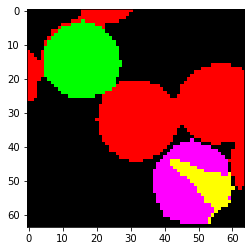

In [26]:
imshow(classes=ch_pred_ord)

In [27]:
ch_label = np.load(r"E:\intermediate_notebooks\hermi_ch_gt_cat\0876.npy")
ch_label.shape

(64, 64, 6)

In [28]:
ch_label_ord = np.argmax(ch_label, axis=2)
ch_label_ord.shape

(64, 64)

ImageView object:
  Interpolation       :  <default>

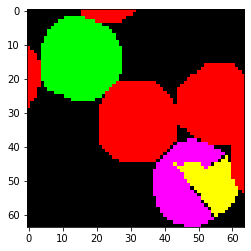

In [29]:
imshow(classes = ch_label_ord)

In [30]:
hermi_2004_final = load_data(r"E:\intermediate_notebooks\hermi2004_final");# List containing names (string) of the datasets in hermi_2004
hermi_2007_final = load_data(r"E:\intermediate_notebooks\hermi2007_final");# List containing names (string) of the datasets in hermi_2004

E:\intermediate_notebooks\hermi2004_final----------
Number of Samples :    28
E:\intermediate_notebooks\hermi2007_final----------
Number of Samples :    28


In [31]:
counter = 0;
hermi_org = np.zeros((2, 64, 64, 242))
for i in range(len(hermi_2004_final)):
    #print("Loading file number: ", all_final[counter])
    temp1 = np.load(hermi_2004_final[i])
    temp2 = np.load(hermi_2007_final[i])
    hermi_org[0, :, :, :] = temp1;
    hermi_org[1, :, :, :] = temp2;
    hermi_pred = cae_encoder.predict(hermi_org)
    hermi_pred = np.expand_dims(hermi_pred, axis=0);
    hermi_pred = ch_best.predict(hermi_pred)
    hermi_pred = np.squeeze(hermi_pred)
    hermi_pred = np.argmax(hermi_pred, axis=2)
    np.save(pathlib.Path(r"E:\cha_detec_desktop1_cae\hermi_change", '{:03d}'.format(counter)).with_suffix(".npy"), hermi_pred)
    counter += 1
print("Loaded "+str(counter)+" files")

Loaded 28 files


In [32]:
all_change = load_data(r"E:\cha_detec_desktop1_cae\hermi_change");# List containing names (string) of the datasets in pavC

E:\cha_detec_desktop1_cae\hermi_change----------
Number of Samples :    28


In [33]:
np.load(all_change[20]).shape

(64, 64)

In [34]:
change_im = np.zeros((448, 256))
change_im.shape

(448, 256)

In [35]:
counter = 0;
for r in range(0, change_im.shape[0], 64):
    for c in range(0, change_im.shape[1], 64):
        temp = np.load(all_change[counter])
        #print(temp.shape)
        change_im[r:r+64, c:c+64] = temp 
        counter +=1;
print(counter)

28


In [36]:
change_im = change_im[0:390, 0:200]

ImageView object:
  Interpolation       :  <default>

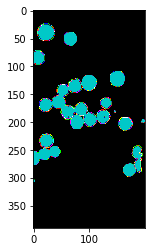

In [37]:
imshow(classes=change_im)

In [38]:
gt_all_final = load_data(r"E:\intermediate_notebooks\hermi_ch_gt_final");# List containing names (string) of the datasets in pavC

E:\intermediate_notebooks\hermi_ch_gt_final----------
Number of Samples :    28


In [39]:
final_im = np.zeros((448, 256))

In [40]:
counter = 0;
for r in range(0, final_im.shape[0], 64):
    for c in range(0, final_im.shape[1], 64):
        temp = np.load(gt_all_final[counter])
        #print(temp.shape)
        final_im[r:r+64, c:c+64] = temp 
        counter +=1;
print(counter)

28


In [41]:
final_im = final_im[0:390, 0:200]

ImageView object:
  Interpolation       :  <default>

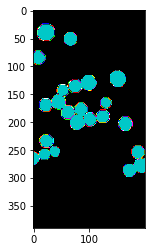

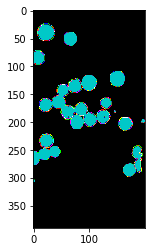

In [42]:
imshow(classes=final_im)
imshow(classes=change_im)

In [75]:
np.save(pathlib.Path(r"E:\cha_detec_desktop1_cae", "hermi_change_recon_large").with_suffix(".npy"), change_im);
np.save(pathlib.Path(r"E:\cha_detec_desktop1_cae", "hermi_change_original_large").with_suffix(".npy"), final_im);

In [46]:
unique = np.unique(final_im, return_counts=True)
count = unique[1]
count

array([68014,  5558,  1331,    79,  1557,  1461], dtype=int64)

In [47]:
confMat = np.zeros((6,6), dtype=np.int64)
classes = np.arange(0, 6)
confMat2 = np.zeros((6,6), dtype=np.float64)

In [48]:
# TO BE CHANGED FOR TWO DIMENSTIONAL ARRAY 
h = 0
for r in range(390):
    for c in range(200):
        confMat[int(final_im[r][c])][int(change_im[r][c])] += 1 
        h = h + 1

In [49]:
# TO BE CHANGED FOR TWO DIMENSTIONAL ARRAY 
h = 0
for r in range(6):
    for c in range(6):
        confMat2[r][c] = (confMat[r][c]*100)/count[r]
        h = h + 1

In [53]:
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Greens):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

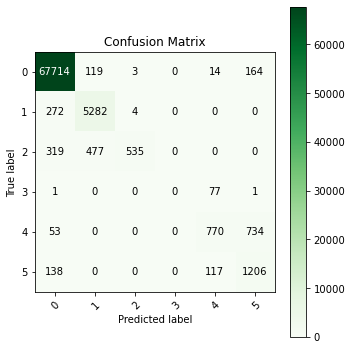

In [54]:
plot_confusion_matrix(confMat, classes, title="Confusion Matrix")

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

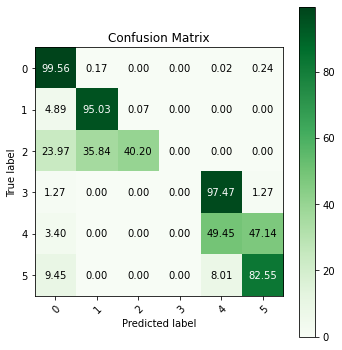

In [55]:
plot_confusion_matrix(confMat2, classes, normalize=True, title="Confusion Matrix")

In [56]:
row_sum = np.sum(confMat, axis=0)
row_sum = np.where(row_sum==0, 1, row_sum)

col_sum = np.sum(confMat, axis=1)
col_sum = np.where(col_sum==0, 1, col_sum)

# Recall = TP / (TP + FN) 
black_recall = np.diag(confMat) / col_sum

# Precision = TP / (TP + FP)
black_precision = np.diag(confMat) / row_sum
h = 0
for i in range(6):
    h = h + confMat[i][i]
    
acc = h/(final_im.shape[0]*final_im.shape[1])



black_recall_non_zero = np.where(black_recall==0, 1, black_recall)

http://localhost:8888/notebooks/cha_detec_desktop1_cae/hermi_ch_detec_cae.ipynb#
black_precision_non_zero = np.where(black_precision==0, 1, black_precision)


# F1 score = (2 * black_recall * black_precision) / (black_recall + black_precision)
black_fl = (2 * black_recall_non_zero * black_precision_non_zero) / (black_recall_non_zero + black_precision_non_zero)

print("Accu = " + str(np.mean(acc)))
print("Recall = " + str(np.mean(black_recall)))
print("Precision = " + str(np.mean(black_precision)))
print("F1 = " + str(np.mean(black_fl)))

Accu = 0.9680384615384615
Recall = 0.6113145345597717
Precision = 0.7057502265920713
F1 = 0.7951625571495745
